In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Read Train data

In [20]:
train = pd.read_csv('train.csv',nrows=25000000,dtype={'Semana':'int32','Agencia_ID':'int32',
                                       'Canal_ID':'int32','Ruta_SAK':'int32',
                                      'Cliente_ID':'int32','Producto_ID':'int32',
                                      'Venta_uni_hoy':'int32','Venta_hoy':'float32',
                                      'Dev_uni_proxima':'int32','Dev_proxima':'float32',
                                      'Demanda_uni_equil':'int32'})

train.columns =['Week_number','Sales_Depot_ID','Sales_Channel_ID','Route_ID','Client_ID','Product_ID',
                                     'Sales_unit_this_week','Sales_this_week', 'Returns_unit_next_week','Returns_next_week', 
                                     'Adjusted_Demand']
train.loc[:,'Sales_this_week']*=0.056
train.loc[:,'Returns_next_week']*=0.056
train.shape

(25000000, 11)

In [6]:
train1 = pd.read_csv('train.csv',skiprows=range(1, 25000001),nrows=25000000,dtype={'Semana':int,'Agencia_ID':int,
                                       'Canal_ID':int,'Ruta_SAK':int,
                                      'Cliente_ID':int,'Producto_ID':int,
                                      'Venta_uni_hoy':int,'Venta_hoy':float,
                                      'Dev_uni_proxima':int,'Dev_proxima':float,
                                      'Demanda_uni_equil':int})

train1.columns =['Week_number','Sales_Depot_ID','Sales_Channel_ID','Route_ID','Client_ID','Product_ID',
                                     'Sales_unit_this_week','Sales_this_week', 'Returns_unit_next_week','Returns_next_week', 
                                     'Adjusted_Demand']
train1.loc[:,'Sales_this_week']*=0.056
train1.loc[:,'Returns_next_week']*=0.056

train1.shape

(25000000, 11)

In [14]:
train2 = pd.read_csv('train.csv',skiprows=range(1, 50000001),dtype={'Semana':int,'Agencia_ID':int,
                                       'Canal_ID':int,'Ruta_SAK':int,
                                      'Cliente_ID':int,'Producto_ID':int,
                                      'Venta_uni_hoy':int,'Venta_hoy':float,
                                      'Dev_uni_proxima':int,'Dev_proxima':float,
                                      'Demanda_uni_equil':int})

train1.columns =['Week_number','Sales_Depot_ID','Sales_Channel_ID','Route_ID','Client_ID','Product_ID',
                                     'Sales_unit_this_week','Sales_this_week', 'Returns_unit_next_week','Returns_next_week', 
                                     'Adjusted_Demand']
train1.loc[:,'Sales_this_week']*=0.056
train1.loc[:,'Returns_next_week']*=0.056

train2.shape

(24180464, 11)

# Read other files

In [2]:
test  = pd.read_csv('test.csv')
client = pd.read_csv('client.csv')
product = pd.read_csv('product.csv')
town = pd.read_csv('town_state.csv')

#change column names
test.columns = ['id', 'Week_number', 'Sales_Depot_ID', 'Sales_Channel_ID', 'Route_ID', 'Client_ID','Product_ID']
client.columns = ['Client_ID', 'Client_name']
product.columns = ['Product_ID', 'Product_Name']
town.columns = ['Sales_Depot_ID', 'Town', 'State']

test.drop('id',axis=1,inplace=True)

# Preprocess Client data

In [3]:
#Drop duplicate client values
client.drop_duplicates(['Client_ID'],inplace=True)

#in client table some words mean not defiened
client.loc[(client['Client_name'] == 'NO IDENTIFICADO') | (client['Client_name'] == 'SIN NOMBRE') |
           (client['Client_name'] == 'INACTIVAR NO TOCAR') ,'Client_name' ] = 'NO_Name'

# Preprocess Product data

In [4]:
id_list = product['Product_ID'].values
name_list = product['Product_Name'].values
num_product = name_list.shape[0]

product_weight_list = np.empty(num_product)
product_weight_list[:] = np.NAN
product_piece_list = np.ones(num_product)
product_brand_list = list()
product_short_name_list = list()

product_info_list = zip(id_list,name_list)

#extract weight,piece,brand and prod_name

regex_piece_weight = re.compile(r'(.*?)(\d+)(p|P).*?(\d+)\s*(kg|Kg|g|G|ml)') #check for line with piece first and then weight
regex_weight_piece = re.compile(r'(.*?)(\d+)\s*(kg|Kg|g|G|ml).*?(\d+)(p|P)') #opp of first
regex_weight = re.compile(r'(.*?)(\d+)\s*(kg|Kg|g|G|ml)')  #line with only weights
regex_piece = re.compile(r'(.*?)(\d+)(p|P)(?!ct|CT)')  #line with only piece

dont_know_list = ['MTB', 'MTA', 'TNB', 'CU', 'TAB']

for i, (product_id, orig_product_name) in enumerate(product_info_list):
    product_name = orig_product_name.rstrip(str(product_id)).strip()
    
    product_name_words = product_name.split()   
    
    if re.search(regex_piece_weight, product_name):
        regex_result = re.search(regex_piece_weight, product_name)
        product_weight_list[i] = float(regex_result.group(4))
        product_piece_list[i] = int(regex_result.group(2))
        product_short_name = regex_result.group(1)
        if regex_result.group(5) == 'kg' or regex_result.group(5) == 'Kg':
            product_weight_list[i] *= 1000
            
    elif re.search(regex_weight_piece, product_name):
        regex_result = re.search(regex_weight_piece, product_name)
        product_weight_list[i] = float(regex_result.group(2))
        product_piece_list[i] = int(regex_result.group(4))
        if regex_result.group(3) == 'kg' or regex_result.group(3) == 'Kg':
            product_weight_list[i] *= 1000
        product_short_name = regex_result.group(1)
        
    elif re.search(regex_weight, product_name):
        regex_result = re.search(regex_weight, product_name)
        product_weight_list[i] = float(regex_result.group(2))
        if regex_result.group(3) == 'kg' or regex_result.group(3) == 'Kg':
            product_weight_list[i] *= 1000
        product_short_name = regex_result.group(1)
        
    elif re.search(regex_piece, product_name):
        regex_result = re.search(regex_piece, product_name)
        product_piece_list[i] = int(regex_result.group(2))
        product_short_name = regex_result.group(1) 
        
    else:
        product_short_name = ' '.join([word for word in product_name_words[:-1] if word not in dont_know_list])
        
    product_brand_list.append(product_name_words[-1])
    product_short_name_list.append(product_short_name)
    
product['product_name'] = product_short_name_list
product['brand'] = product_brand_list
product['weight'] = product_weight_list
product['pieces'] = product_piece_list

product.drop('Product_Name',axis = 1,inplace=True)
product.head()

,Product_ID,product_name,brand,weight,pieces
0,0,NO,IDENTIFICADO,NaN,1.0
1,9,Capuccino Moka,NES,750.0,1.0
2,41,Bimbollos Ext sAjonjoli,BIM,480.0,6.0
3,53,Burritos Sincro,LON,170.0,1.0
4,72,Div Tira Mini Doradita,TR,45.0,4.0


In [10]:
product.describe()

,Product_ID,weight,pieces
count,2592.000000,2541.000000,2592.000000
mean,32591.095679,413.480913,6.520448
std,13004.091024,1764.304179,13.941169
min,0.000000,4.000000,0.000000
25%,31515.500000,80.000000,1.000000
50%,35224.000000,180.000000,1.000000
75%,40447.250000,400.000000,8.000000
max,49997.000000,42000.000000,200.000000


In [5]:
product['weight'].fillna(4,inplace=True)
product.head()

,Product_ID,product_name,brand,weight,pieces
0,0,NO,IDENTIFICADO,4.0,1.0
1,9,Capuccino Moka,NES,750.0,1.0
2,41,Bimbollos Ext sAjonjoli,BIM,480.0,6.0
3,53,Burritos Sincro,LON,170.0,1.0
4,72,Div Tira Mini Doradita,TR,45.0,4.0


In [6]:
test =pd.merge(test,product,how='inner',on='Product_ID') 
test =pd.merge(test,town,how='inner',on='Sales_Depot_ID')
test =pd.merge(test,client,how='inner',on='Client_ID')
test.drop(['Client_ID','Product_ID','Sales_Depot_ID'],axis=1,inplace=True)

In [7]:
test.head()

,Week_number,Sales_Channel_ID,Route_ID,product_name,brand,weight,pieces,Town,State,Client_name
0,11,1,2209,Barritas Fresa,MLA,75.0,1.0,2499 REYNOSA MARINELA,TAMAULIPAS,NO_Name
1,10,1,2209,Barritas Fresa,MLA,75.0,1.0,2499 REYNOSA MARINELA,TAMAULIPAS,NO_Name
2,10,1,2209,Triki Trakes,MLA,69.0,8.0,2499 REYNOSA MARINELA,TAMAULIPAS,NO_Name
3,11,1,2209,Barritas Pina,MLA,75.0,1.0,2499 REYNOSA MARINELA,TAMAULIPAS,NO_Name
4,11,1,2101,Barritas Fresa,MLA,75.0,1.0,2499 REYNOSA MARINELA,TAMAULIPAS,MS PALOMO


In [17]:
train =pd.merge(train,product,how='inner',on='Product_ID') 
train =pd.merge(train,town,how='inner',on='Sales_Depot_ID')
train =pd.merge(train,client,how='inner',on='Client_ID')
train.drop(['Client_ID','Product_ID','Sales_Depot_ID'],axis=1,inplace=True)
train.shape

(25000000, 18)

In [9]:
train1 =pd.merge(train1,product,how='inner',on='Product_ID') 
train1 =pd.merge(train1,town,how='inner',on='Sales_Depot_ID')
train1 =pd.merge(train1,client,how='inner',on='Client_ID')
train.drop(['Client_ID','Product_ID','Sales_Depot_ID'],axis=1,inplace=True)
train1.shape

(25000000, 18)

In [ ]:
train2 =pd.merge(train2,product,how='inner',on='Product_ID') 
train2 =pd.merge(train2,town,how='inner',on='Sales_Depot_ID')
train2 =pd.merge(train2,client,how='inner',on='Client_ID')
train.drop(['Client_ID','Product_ID','Sales_Depot_ID'],axis=1,inplace=True)
train2.shape

# Data Visualization

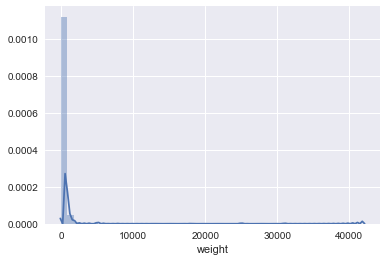

In [21]:
sns.distplot(product.weight.dropna())

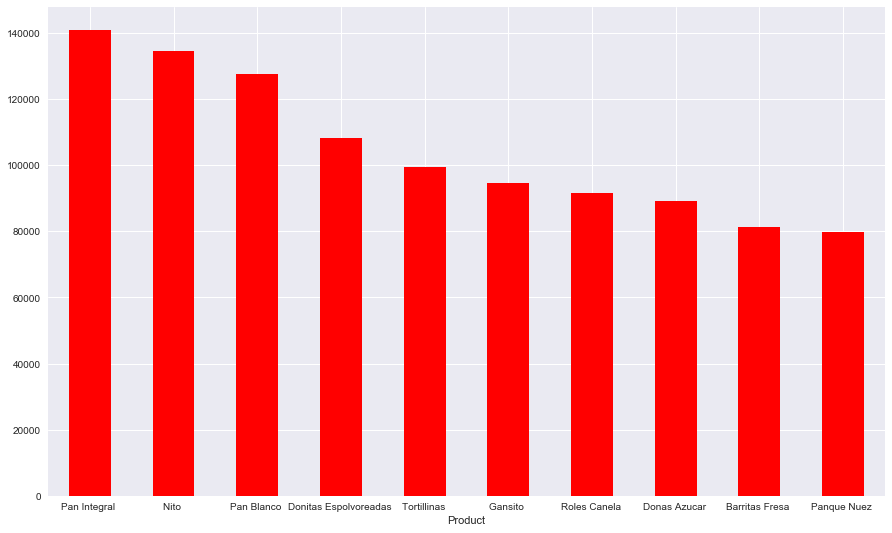

In [14]:
#Top 10 selling products in 11th week

t = test.loc[test['Week_number'] == 11]
t = t.product_name.value_counts(sort=True)
t.head(10).plot(kind='bar', color='red', rot=0,figsize=(15,9))
plt.xlabel('Product')
sns.despine()
del t

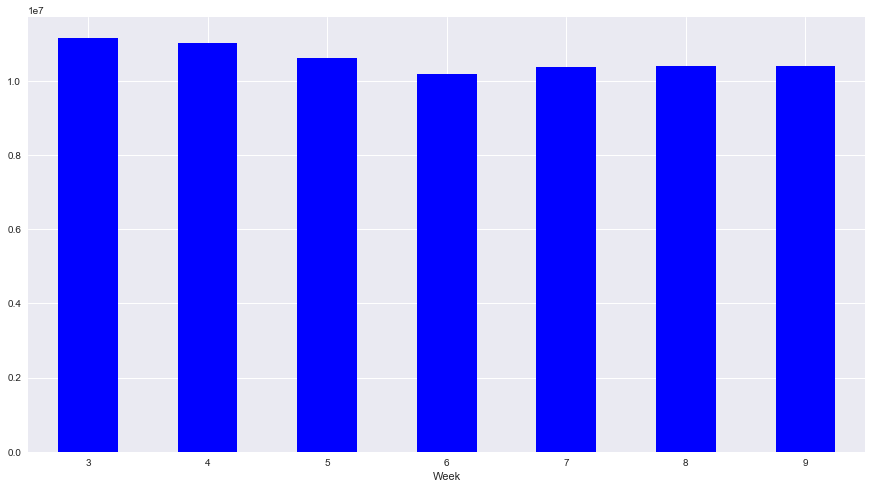

In [20]:
t = pd.read_csv('train.csv',usecols=[0],dtype={'Semana':'int32'})
t.Semana.value_counts(sort=False).plot(kind='bar', color='blue', rot=0,figsize=(15,8))
plt.xlabel('Week')
sns.despine()
del t

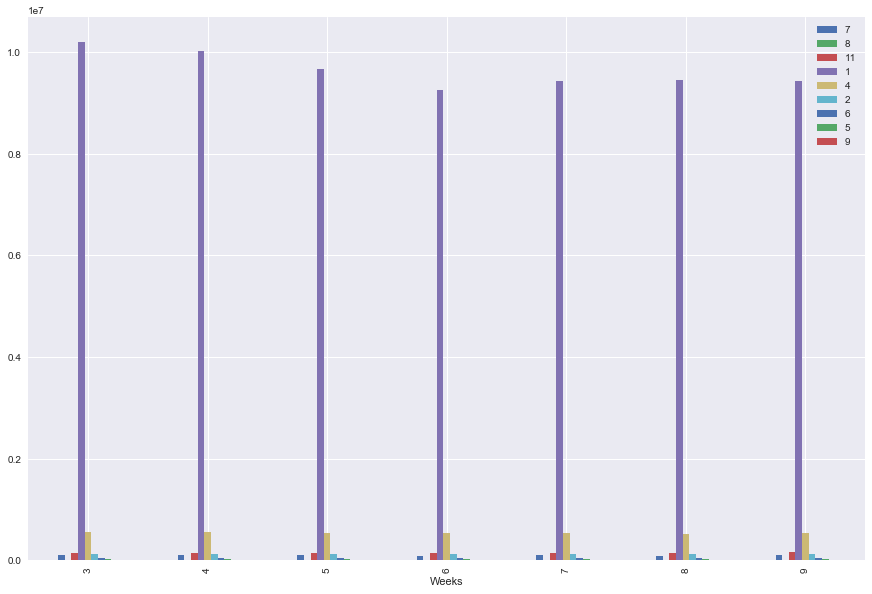

In [25]:
t = pd.read_csv('train.csv',usecols=[0,2],dtype={'Semana':'int32','Canal_ID':'int32'})
list1 = list(t['Semana'].drop_duplicates())
list2 = list(t['Canal_ID'].drop_duplicates())
dev_sin = pd.DataFrame()
dev_sin['Semana']=list1
for x in list2:
    sin=[]
    for y in list1:
        occ = t.loc[(t['Semana'] == y ) & (t['Canal_ID'] == x)].Canal_ID.count()
        sin.append(occ)
    dev_sin[x]=sin
    
dev_sin.set_index('Semana',inplace=True)
dev_sin.plot(kind='bar', legend=True,figsize=(15,10))
plt.xlabel('Weeks')
sns.despine()
del dev_sin
del t